Spark K-means. Data set MovieLens

In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

In [2]:
df = pd.read_csv('merg_1.csv')

In [67]:
df.shape

(100004, 8)

In [3]:
df.head(2)

,Unnamed: 0,userId,movieId,rating,timestamp,title,genres,cat_genre
0,0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama,0.0
1,1,7,31,3.0,851868750,Dangerous Minds (1995),Drama,0.0


In [3]:
X1 = df[['userId', 'rating']]
X = np.array(X1)

In [4]:
Y = df['cat_genre']
y = np.array(Y)

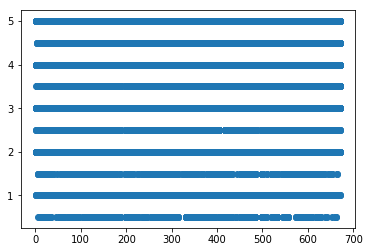

In [5]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()
plt.gcf().clear()

In [6]:
k = 3
centroids = np.array(X[:k])
print(centroids)

[[  1.    2.5]
 [  7.    3. ]
 [ 31.    4. ]]


In [7]:
os.environ["JAVA_HOME"] = '/usr/lib/jvm/java-1.8.0-openjdk-amd64'
os.environ["PYSPARK_SUBMIT_ARGS"] = 'pyspark-shell'
os.environ["SPARK_HOME"] = '/opt/spark'
sys.path.append(os.environ['SPARK_HOME']+"/python")
sys.path.append(os.environ['SPARK_HOME']+"/python/lib/py4j-0.10.4-src.zip")

In [8]:
sc = SparkContext(appName="StreamingKMeansExample")  # SparkContext

In [9]:
rdd = sc.parallelize(X)
rdd.cache()

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:480

In [10]:
def cost_function(x, y):
    return sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

In [11]:
d = rdd.map(lambda x: (x, [cost_function(x, centroids[i]) for i in range(k)]))

In [12]:
assignments = d.map(lambda (x, c): (c.index(min(c)), x))
assignments.take(10)

[(0, array([ 1. ,  2.5])),
 (1, array([ 7.,  3.])),
 (2, array([ 31.,   4.])),
 (2, array([ 32.,   4.])),
 (2, array([ 36.,   3.])),
 (2, array([ 39.,   3.])),
 (2, array([ 73. ,   3.5])),
 (2, array([ 88.,   3.])),
 (2, array([ 96. ,   2.5])),
 (2, array([ 110.,    4.]))]

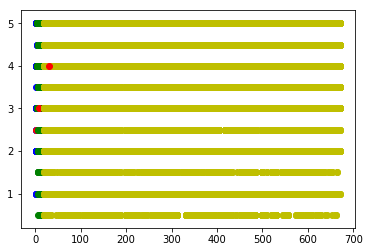

In [13]:
colours = ['b','g','y']
for i in range(k):
    all_assigned = np.array(assignments.filter(lambda (a, x): a==i).map(lambda (c, x): x).collect())
    plt.scatter(all_assigned[:,0], all_assigned[:,1], color = colours[i])
    plt.scatter([centroids[i][0]], [centroids[i][1]], color=['r'])

plt.show()
plt.gcf().clear()

In [14]:
c0 = assignments.filter(lambda (a, x): a==0).map(lambda (a, x): x)
c1 = assignments.filter(lambda (a, x): a==1).map(lambda (a, x): x)
c2 = assignments.filter(lambda (a, x): a==2).map(lambda (a, x): x)
c0.take(5)

[array([ 1. ,  2.5]),
 array([ 1.,  3.]),
 array([ 1.,  3.]),
 array([ 1.,  2.]),
 array([ 1.,  4.])]

In [15]:
new_centroids = [c0.sum()/c0.count(), c1.sum()/c1.count(), c2.sum()/c2.count()]

print(new_centroids)

[array([ 2.32484076,  3.26751592]), array([ 13.67496847,   3.09205549]), array([ 358.50816654,    3.55887251])]


In [16]:
d1 = rdd.map(lambda x: (x, [cost_function(x, new_centroids[i]) for i in range(k)]))
new_assignments = d1.map(lambda (x, c): (c.index(min(c)), x))
new_assignments.take(10)

[(0, array([ 1. ,  2.5])),
 (0, array([ 7.,  3.])),
 (1, array([ 31.,   4.])),
 (1, array([ 32.,   4.])),
 (1, array([ 36.,   3.])),
 (1, array([ 39.,   3.])),
 (1, array([ 73. ,   3.5])),
 (1, array([ 88.,   3.])),
 (1, array([ 96. ,   2.5])),
 (1, array([ 110.,    4.]))]

In [21]:
colours = ['b','g','y']
for i in range(k):
    print i
    all_assigned = np.array(new_assignments.filter(lambda (a, x): a == i).map(lambda (c, x): x).collect())
    print all_assigned.shape
    plt.scatter(all_assigned[:,0], all_assigned[:,1], color = colours[i])
    plt.scatter([new_centroids[i][0]], [new_centroids[i][1]], color=['r'])

plt.show()
plt.gcf().clear()

0
(15265, 2)
1
(0,)


IndexError: too many indices for array

In [23]:
def assign(rdd, centroids):
    d = rdd.map(lambda x: (x, [cost_function(x, centroids[i]) for i in range(k)]))
    
    return d.map(lambda (x, c): (c.index(min(c)), x))

def recalculate_centroids(assignments):
    new_centroids = []
    for i in range(k):
        a = assignments.filter(lambda (a, x): a==i).map(lambda (a, x): x)
        c = a.sum()/a.count()
        new_centroids.append(c)
        
    return new_centroids

def iteration(rdd, centroids):
    assigned = assign(rdd, centroids)
    new_centroids = recalculate_centroids(assigned)
    return assigned, new_centroids

assigned, new_centroids = iteration(rdd, new_centroids)

In [60]:
assignments.take(5)

[(0, array([ 0. ,  2.5])),
 (1, array([ 0.,  3.])),
 (2, array([ 0.,  4.])),
 (2, array([ 0.,  4.])),
 (1, array([ 0.,  3.]))]

In [68]:
k1=[]
for i in assignments.take(100004): k1.append(i[0])

In [71]:
def draw_clusters(assignments, centroids):
    colours = ['b','g','y']

    for i in range(k):
        all_assigned = np.array(assignments.filter(lambda (a, x): a == i).map(lambda (c, x): x).collect())        
        plt.scatter(all_assigned[:,0], all_assigned[:,1], color=colours[i])
        plt.scatter([centroids[i][0]], [centroids[i][1]], color=['r'])

    plt.show()
    plt.gcf().clear()

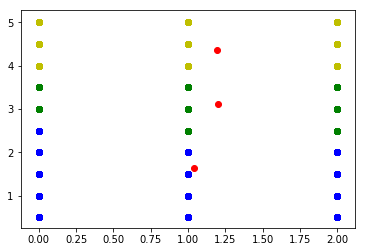

In [72]:
draw_clusters(assigned, new_centroids)

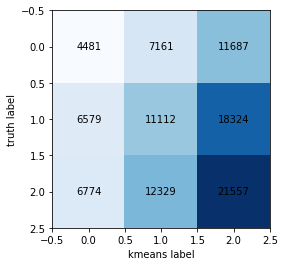

In [75]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, k1)

# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()